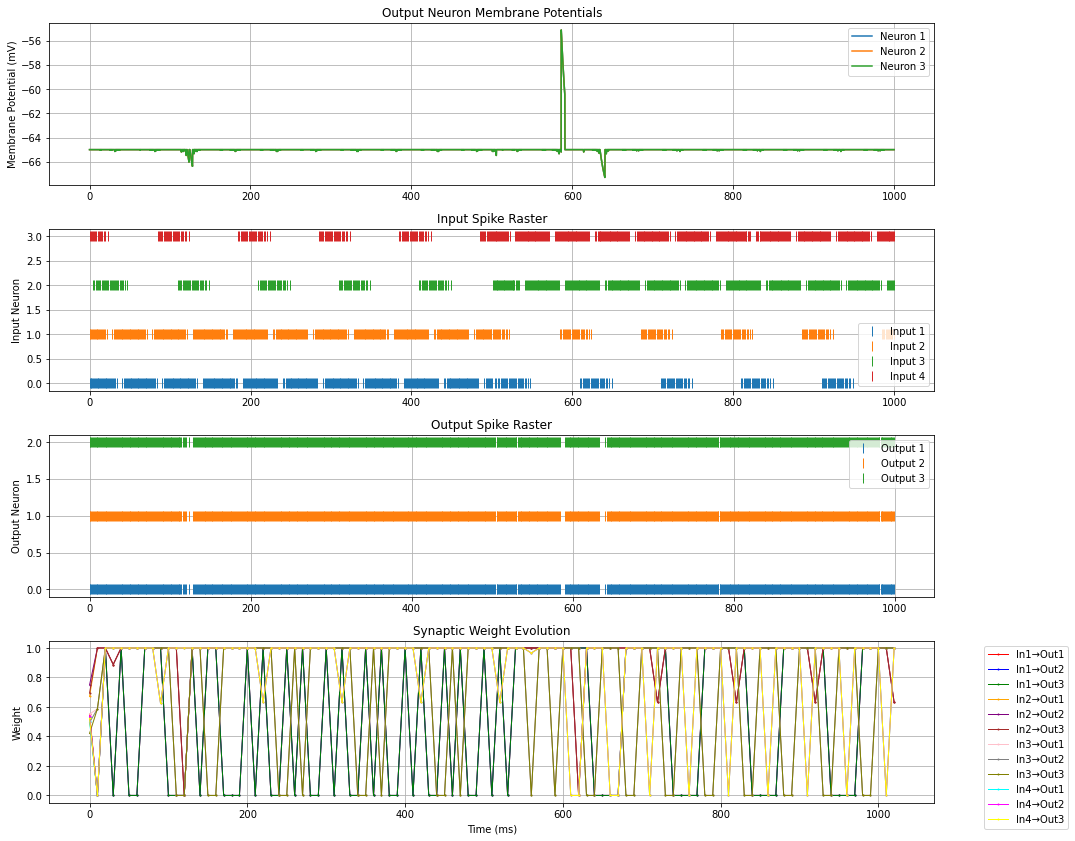

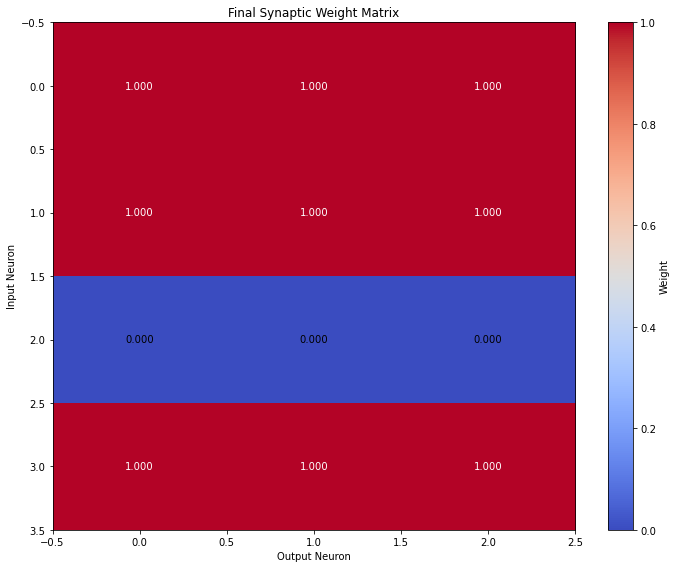


Neuron Spiking Statistics:
Input neurons:
Input 1: 504 spikes
Input 2: 500 spikes
Input 3: 503 spikes
Input 4: 501 spikes

Output neurons:
Output 1: 861 spikes
Output 2: 861 spikes
Output 3: 861 spikes

Weight Changes Summary:
In1→Out1: 0.550 → 1.000 (Δ = 0.450)
In1→Out2: 0.535 → 1.000 (Δ = 0.465)
In1→Out3: 0.524 → 1.000 (Δ = 0.476)
In2→Out1: 0.671 → 0.630 (Δ = -0.041)
In2→Out2: 0.749 → 0.630 (Δ = -0.119)
In2→Out3: 0.695 → 0.630 (Δ = -0.064)
In3→Out1: 0.551 → 1.000 (Δ = 0.449)
In3→Out2: 0.495 → 1.000 (Δ = 0.505)
In3→Out3: 0.421 → 1.000 (Δ = 0.579)
In4→Out1: 0.506 → 1.000 (Δ = 0.494)
In4→Out2: 0.539 → 1.000 (Δ = 0.461)
In4→Out3: 0.523 → 1.000 (Δ = 0.477)

Detailed Weight Change Events:

Synapse In1→Out1 changes:
Time 0.1ms: 0.550 → 0.342 (Δ = -0.208)
Time 1.1ms: 0.342 → 0.523 (Δ = 0.181)
Time 1.2ms: 0.523 → 0.129 (Δ = -0.394)
Time 2.2ms: 0.129 → 0.472 (Δ = 0.343)
Time 2.3ms: 0.472 → 0.000 (Δ = -0.472)

Synapse In1→Out2 changes:
Time 0.1ms: 0.535 → 0.327 (Δ = -0.208)
Time 1.1ms: 0.327 →

In [3]:
# Spiking Neural Network with STDP Learning - Debug Version
import numpy as np
import matplotlib.pyplot as plt

class LIFNeuron:
    """
    Leaky Integrate-and-Fire Neuron with adjusted parameters for more activity
    """
    def __init__(self, tau_m=10.0, v_rest=-70.0, v_reset=-65.0, v_thresh=-50.0, 
                 refractory_period=1.0):
        self.tau_m = tau_m  # Decreased time constant for faster response
        self.v_rest = v_rest
        self.v_reset = v_reset
        self.v_thresh = v_thresh
        self.refractory_period = refractory_period  # Shorter refractory period
        
        self.v = v_rest
        self.last_spike = -np.inf
        self.I = 0
        self.spike_count = 0  # For debugging
        
    def step(self, t, dt):
        if (t - self.last_spike) <= self.refractory_period:
            self.v = self.v_reset
            return 0
        
        # More sensitive membrane potential update
        dv = (-(self.v - self.v_rest) + self.I * 50) * (dt / self.tau_m)  # Increased current sensitivity
        self.v += dv
        
        if self.v >= self.v_thresh:
            self.last_spike = t
            self.v = self.v_reset
            self.spike_count += 1
            return 1
        return 0

class Synapse:
    def __init__(self, pre_neuron, post_neuron, w_init=0.5):
        self.pre_neuron = pre_neuron
        self.post_neuron = post_neuron
        self.weight = w_init
        
        # Increased learning rates and adjusted time constants
        self.tau_pre = 10.0  # Faster trace decay
        self.tau_post = 10.0
        self.A_plus = 0.2    # Much stronger LTP
        self.A_minus = -0.21 # Slightly stronger LTD
        self.w_max = 1.0
        self.w_min = 0.0
        
        self.trace_pre = 0.0
        self.trace_post = 0.0
        self.weight_changes = []  # Track all weight changes
        
    def update(self, t, dt, pre_spike, post_spike):
        # Decay traces
        self.trace_pre *= np.exp(-dt / self.tau_pre)
        self.trace_post *= np.exp(-dt / self.tau_post)
        
        old_weight = self.weight
        
        if pre_spike:
            self.trace_pre += 1.0
            dw = self.A_minus * self.trace_post
            self.weight = np.clip(self.weight + dw, self.w_min, self.w_max)
            
        if post_spike:
            self.trace_post += 1.0
            dw = self.A_plus * self.trace_pre
            self.weight = np.clip(self.weight + dw, self.w_min, self.w_max)
            
        if abs(old_weight - self.weight) > 0.001:
            self.weight_changes.append((t, old_weight, self.weight))

class SNN:
    def __init__(self, n_input, n_output):
        self.input_neurons = [LIFNeuron() for _ in range(n_input)]
        self.output_neurons = [LIFNeuron() for _ in range(n_output)]
        
        # Initialize synapses with random weights
        self.synapses = []
        for pre in self.input_neurons:
            for post in self.output_neurons:
                w_init = np.random.uniform(0.4, 0.6)  # Random initial weights
                self.synapses.append(Synapse(pre, post, w_init))
    
    def step(self, t, dt, input_currents):
        for n in self.output_neurons:
            n.I = 0
            
        input_spikes = []
        for n, I in zip(self.input_neurons, input_currents):
            n.I = I
            input_spikes.append(n.step(t, dt))
            
        # Stronger synaptic transmission
        for syn in self.synapses:
            pre_idx = self.input_neurons.index(syn.pre_neuron)
            if input_spikes[pre_idx]:
                syn.post_neuron.I += 100 * syn.weight  # Increased synaptic strength
                
        output_spikes = []
        for n in self.output_neurons:
            output_spikes.append(n.step(t, dt))
            
        for syn in self.synapses:
            pre_idx = self.input_neurons.index(syn.pre_neuron)
            post_idx = self.output_neurons.index(syn.post_neuron)
            syn.update(t, dt, input_spikes[pre_idx], output_spikes[post_idx])
            
        return input_spikes, output_spikes
    
    def get_weights_matrix(self):
        W = np.zeros((len(self.input_neurons), len(self.output_neurons)))
        for syn in self.synapses:
            i = self.input_neurons.index(syn.pre_neuron)
            j = self.output_neurons.index(syn.post_neuron)
            W[i, j] = syn.weight
        return W

# Simulation parameters
T = 1000  # Simulation time
dt = 0.1   # Time step
time = np.arange(0, T, dt)

# Create network
n_input = 4
n_output = 3
network = SNN(n_input, n_output)

# Generate stronger input patterns
def generate_input_pattern(t, pattern_id=0):
    if pattern_id == 0:
        return [
            30 * (1 + np.sin(2 * np.pi * t / 50)),  # Faster oscillation
            30 * (1 + np.sin(2 * np.pi * t / 50 + np.pi/2)),
            10 * np.sin(2 * np.pi * t / 100),
            10 * np.sin(2 * np.pi * t / 100 + np.pi/2)
        ]
    else:
        return [
            10 * np.sin(2 * np.pi * t / 100),
            10 * np.sin(2 * np.pi * t / 100 + np.pi/2),
            30 * (1 + np.sin(2 * np.pi * t / 50)),
            30 * (1 + np.sin(2 * np.pi * t / 50 + np.pi/2))
        ]

# Run simulation
input_spikes_history = []
output_spikes_history = []
weight_history = []
v_history = []
pattern_switch = T/2

for t in time:
    pattern_id = 0 if t < pattern_switch else 1
    input_currents = generate_input_pattern(t, pattern_id)
    
    input_spikes, output_spikes = network.step(t, dt, input_currents)
    
    input_spikes_history.append(input_spikes)
    output_spikes_history.append(output_spikes)
    v_history.append([n.v for n in network.output_neurons])
    
    if int(t/dt) % 100 == 0:
        weight_history.append(network.get_weights_matrix())

# Convert to numpy arrays
input_spikes_history = np.array(input_spikes_history)
output_spikes_history = np.array(output_spikes_history)
v_history = np.array(v_history)
weight_history = np.array(weight_history)

# Plotting
plt.figure(figsize=(15, 12))

# Plot membrane potentials
plt.subplot(411)
for i in range(n_output):
    plt.plot(time, v_history[:, i], label=f'Neuron {i+1}')
plt.ylabel('Membrane Potential (mV)')
plt.title('Output Neuron Membrane Potentials')
plt.legend()
plt.grid(True)

# Plot input spike raster
plt.subplot(412)
for i in range(n_input):
    spike_times = time[input_spikes_history[:, i] > 0]
    plt.plot(spike_times, [i] * len(spike_times), '|', markersize=10, label=f'Input {i+1}')
plt.ylabel('Input Neuron')
plt.title('Input Spike Raster')
plt.legend()
plt.grid(True)

# Plot output spike raster
plt.subplot(413)
for i in range(n_output):
    spike_times = time[output_spikes_history[:, i] > 0]
    plt.plot(spike_times, [i] * len(spike_times), '|', markersize=10, label=f'Output {i+1}')
plt.ylabel('Output Neuron')
plt.title('Output Spike Raster')
plt.legend()
plt.grid(True)

# Plot weight evolution with distinct colors
plt.subplot(414)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
for idx, (i, j) in enumerate([(i, j) for i in range(n_input) for j in range(n_output)]):
    plt.plot(np.arange(len(weight_history)) * 100 * dt, weight_history[:, i, j], 
             label=f'In{i+1}→Out{j+1}',
             color=colors[idx % len(colors)],
             marker='.',
             markersize=2,
             linewidth=1)
plt.xlabel('Time (ms)')
plt.ylabel('Weight')
plt.title('Synaptic Weight Evolution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot detailed weight matrix
final_weights = network.get_weights_matrix()
plt.figure(figsize=(10, 8))
im = plt.imshow(final_weights, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im, label='Weight')
plt.xlabel('Output Neuron')
plt.ylabel('Input Neuron')
plt.title('Final Synaptic Weight Matrix')

# Add text annotations
for i in range(final_weights.shape[0]):
    for j in range(final_weights.shape[1]):
        plt.text(j, i, f'{final_weights[i,j]:.3f}', 
                ha='center', va='center',
                color='white' if final_weights[i,j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

# Print statistics
print("\nNeuron Spiking Statistics:")
print("Input neurons:")
for i, neuron in enumerate(network.input_neurons):
    print(f"Input {i+1}: {neuron.spike_count} spikes")
print("\nOutput neurons:")
for i, neuron in enumerate(network.output_neurons):
    print(f"Output {i+1}: {neuron.spike_count} spikes")

print("\nWeight Changes Summary:")
initial_weights = weight_history[0]
final_weights = weight_history[-1]
for i in range(n_input):
    for j in range(n_output):
        change = final_weights[i,j] - initial_weights[i,j]
        print(f"In{i+1}→Out{j+1}: {initial_weights[i,j]:.3f} → {final_weights[i,j]:.3f} (Δ = {change:.3f})")

# Print significant weight changes from synapses
print("\nDetailed Weight Change Events:")
for syn in network.synapses:
    if len(syn.weight_changes) > 0:
        i = network.input_neurons.index(syn.pre_neuron)
        j = network.output_neurons.index(syn.post_neuron)
        print(f"\nSynapse In{i+1}→Out{j+1} changes:")
        for t, old_w, new_w in syn.weight_changes[:5]:  # Show first 5 changes
            print(f"Time {t:.1f}ms: {old_w:.3f} → {new_w:.3f} (Δ = {new_w - old_w:.3f})")